In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Dataset

In [ ]:
class ImagePredictionDataset(Dataset):
    def __init__(self, num_processes=4, is_test=False):
        init_imgs_list, actions_list, final_imgs_list = [], [], []
        # This is related to how I store the data (Explained in README.md)
        suffix = "_test" if is_test else ""

        for i in range(num_processes):
            init_imgs_list.append(torch.load(f"dataset/initial_imgs{suffix}_{i}.pt"))
            actions_list.append(torch.load(f"dataset/actions{suffix}_{i}.pt"))
            final_imgs_list.append(torch.load(f"dataset/final_imgs{suffix}_{i}.pt"))

        # Normalizing data helps the model converge faster
        self.init_imgs = torch.cat(init_imgs_list, dim=0).float() / 255.0
        self.final_imgs = torch.cat(final_imgs_list, dim=0).float() / 255.0
        self.actions = torch.cat(actions_list, dim=0).long()

    def __len__(self):
        return len(self.actions)

    def __getitem__(self, idx):
        return self.init_imgs[idx], self.actions[idx], self.final_imgs[idx]

In [ ]:
class PositionPredictionDataset(Dataset):
    def __init__(self, num_processes=4, is_test=False, train_min=None, train_max=None):
        init_imgs_list, actions_list, final_obj_positions_list = [], [], []
        suffix = "_test" if is_test else ""

        for i in range(num_processes):
            init_imgs_list.append(torch.load(f"dataset/initial_imgs{suffix}_{i}.pt"))
            actions_list.append(torch.load(f"dataset/actions{suffix}_{i}.pt"))
            final_obj_positions_list.append(torch.load(f"dataset/final_obj_positions{suffix}_{i}.pt"))

        self.init_imgs = torch.cat(init_imgs_list, dim=0).float() / 255.0
        self.final_obj_positions = torch.cat(final_obj_positions_list, dim=0).float()
        self.actions = torch.cat(actions_list, dim=0).long()

        # This condition is needed to normalize the test data with the same values
        if train_min is not None and train_max is not None:
            self.pos_min = train_min
            self.pos_max = train_max
        else:
            self.pos_min = self.final_obj_positions.min(dim=0)[0]
            self.pos_max = self.final_obj_positions.max(dim=0)[0]

        self.final_obj_positions = (self.final_obj_positions - self.pos_min) / (self.pos_max - self.pos_min)

    def __len__(self):
        return len(self.actions)

    def __getitem__(self, idx):
        return self.init_imgs[idx], self.actions[idx], self.final_obj_positions[idx]

# Models

In [4]:
class ImgMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(49156, 1024)  # 49,152 from pixels + 4 from actions
        self.ln1 = nn.LayerNorm(1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.ln2 = nn.LayerNorm(1024)
        self.fc3 = nn.Linear(1024, 49152)  # predict image

    def forward(self, img, action):
        batch_size = img.size(0)
        img_flat = img.view(batch_size, -1)
        action_one_hot = F.one_hot(action.long(), num_classes=4).float()  # e.g. Action 0: 1 0 0 0

        x = torch.cat((img_flat, action_one_hot), dim=1)
        x = F.relu(self.ln1(self.fc1(x)))
        x = F.relu(self.ln2(self.fc2(x)))
        x = self.fc3(x)
        x = torch.sigmoid(x)  # To stay in [0, 1]

        output_img = x.view(batch_size, 3, 128, 128)
        return output_img

In [5]:
class ImgCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # (kernel_size=3, padding=1) combination keeps the image in the same size
        self.conv1 = nn.Conv2d(in_channels=7, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding=1)

    def forward(self, img, action):
        batch_size = img.size(0)
        action_one_hot = F.one_hot(action.long(), num_classes=4).float()
        action_spatial = action_one_hot.view(batch_size, 4, 1, 1).expand(-1, -1, 128, 128)

        x = torch.cat((img, action_spatial), dim=1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)

        output_img = torch.sigmoid(x)
        return output_img

In [6]:
class PositionMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(49156, 2048)  # 49,152 from pixels + 4 from actions
        self.ln1 = nn.LayerNorm(2048)
        self.fc2 = nn.Linear(2048, 512)
        self.ln2 = nn.LayerNorm(512)
        self.fc3 = nn.Linear(512, 256)
        self.ln3 = nn.LayerNorm(256)
        self.fc4 = nn.Linear(256, 2)  # Predict (x, y)

    def forward(self, img, action):
        batch_size = img.size(0)

        img_flat = img.view(batch_size, -1)
        action_one_hot = F.one_hot(action.long(), num_classes=4).float()  # e.g. Action 0: 1 0 0 0
        x = torch.cat((img_flat, action_one_hot), dim=1)

        x = F.relu(self.ln1(self.fc1(x)))
        x = F.relu(self.ln2(self.fc2(x)))
        x = F.relu(self.ln3(self.fc3(x)))

        out_coords = torch.sigmoid(self.fc4(x))  # To stay in [0, 1] since the data is normalized

        return out_coords

In [7]:
class PositionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # (kernel_size=3, padding=1) combination keeps the image in the same size
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2) # 128x128 -> 64x64

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2) # 64x64 -> 32x32

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2) # 32x32 -> 16x16

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2) # 16x16 -> 8x8

        self.fc1 = nn.Linear(8192 + 4, 256)
        self.ln1 = nn.LayerNorm(256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, img, action):
        batch_size = img.size(0)

        x = self.pool1(F.relu(self.conv1(img)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))

        x = x.view(batch_size, -1)

        action_one_hot = F.one_hot(action.long(), num_classes=4).float()
        x = torch.cat((x, action_one_hot), dim=1)

        x = F.relu(self.ln1(self.fc1(x)))

        out_coords = torch.sigmoid(self.fc2(x))

        return out_coords

# Train

In [8]:
def train_img_model(model, train_loader, val_loader, epochs=15, lr=1e-3, device="cpu"):
    model = model.to(device)
    J = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_history, val_history = [], []

    print(f"Training Image Model on {device}")
    for epoch in range(epochs):
        # Train
        model.train()
        running_train_loss = 0.0
        for init_imgs, actions, final_imgs in train_loader:
            init_imgs, actions, final_imgs = init_imgs.to(device), actions.to(device), final_imgs.to(device)

            optimizer.zero_grad()
            predictions = model(init_imgs, actions)
            loss = J(predictions, final_imgs)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * init_imgs.size(0)

        avg_train_loss = running_train_loss / len(train_loader.dataset)
        train_history.append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for init_imgs, actions, final_imgs in val_loader:
                init_imgs, actions, final_imgs = init_imgs.to(device), actions.to(device), final_imgs.to(device)
                predictions = model(init_imgs, actions)
                loss = J(predictions, final_imgs)
                running_val_loss += loss.item() * init_imgs.size(0)

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_history.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}")

    save_path = f"{model.__class__.__name__}_weights.pth"
    torch.save(model.state_dict(), save_path)

    return model, train_history, val_history

In [9]:
def train_position_model(model, train_loader, val_loader, dataset, epochs=15, lr=1e-3, device="cpu"):
    model = model.to(device)
    J = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_history, val_loss_history = [], []
    val_distance_history = []  # In addition to MSE, I wanted to track the distance between true and pred

    pos_min = dataset.pos_min.to(device)
    pos_max = dataset.pos_max.to(device)

    print(f"Training Position Model on {device}")
    for epoch in range(epochs):
        # Train
        model.train()
        running_train_loss = 0.0
        for init_imgs, actions, final_pos in train_loader:
            init_imgs, actions, final_pos = init_imgs.to(device), actions.to(device), final_pos.to(device)

            optimizer.zero_grad()
            predictions = model(init_imgs, actions)
            loss = J(predictions, final_pos)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * init_imgs.size(0)

        avg_train_loss = running_train_loss / len(train_loader.dataset)
        train_loss_history.append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        total_val_distance = 0.0
        with torch.no_grad():
            for init_imgs, actions, true_norm_pos in val_loader:
                init_imgs, actions, true_norm_pos = init_imgs.to(device), actions.to(device), true_norm_pos.to(device)

                pred_norm_pos = model(init_imgs, actions)
                loss = J(pred_norm_pos, true_norm_pos)
                running_val_loss += loss.item() * init_imgs.size(0)

                # Calculate physical distance
                pred_real_pos = (pred_norm_pos * (pos_max - pos_min)) + pos_min
                true_real_pos = (true_norm_pos * (pos_max - pos_min)) + pos_min
                distances = torch.norm(pred_real_pos - true_real_pos, dim=1)
                total_val_distance += distances.sum().item()

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        avg_val_distance = total_val_distance / len(val_loader.dataset)

        val_loss_history.append(avg_val_loss)
        val_distance_history.append(avg_val_distance)

        print(f"Epoch [{epoch+1}/{epochs}] | Train MSE: {avg_train_loss:.5f} | Val MSE: {avg_val_loss:.5f} | Val Dist: {avg_val_distance:.4f}")

    return model, train_loss_history, val_loss_history, val_distance_history

def evaluate_distance_error(model, dataloader, dataset, device="cpu"):
    model.eval()
    total_distance_error = 0.0

    # Normalization factors
    pos_min = dataset.pos_min.to(device)
    pos_max = dataset.pos_max.to(device)

    with torch.no_grad():
        for init_imgs, actions, true_norm_pos in dataloader:
            init_imgs = init_imgs.to(device)
            actions = actions.to(device)
            true_norm_pos = true_norm_pos.to(device)

            pred_norm_pos = model(init_imgs, actions)

            # Unnormalize
            pred_real_pos = (pred_norm_pos * (pos_max - pos_min)) + pos_min
            true_real_pos = (true_norm_pos * (pos_max - pos_min)) + pos_min
            distances = torch.norm(pred_real_pos - true_real_pos, dim=1)

            total_distance_error += distances.sum().item()

    avg_distance = total_distance_error / len(dataloader.dataset)

    save_path = f"{model.__class__.__name__}_weights.pth"
    torch.save(model.state_dict(), save_path)

    return avg_distance

In [10]:
def plot_learning_curves(train_history, val_history, title="Learning Curve", ylabel="MSE Loss"):
    epochs = range(1, len(train_history) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_history, label='Training', color='blue', linewidth=2)
    plt.plot(epochs, val_history, label='Validation', color='orange', linewidth=2, linestyle='--')

    plt.title(title, fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()

Using device: cuda
IMAGE GENERATION
Split 1000 images -> 800 Train | 200 Val

Training Image Model on cuda
Epoch [1/20] | Train Loss: 0.05109 | Val Loss: 0.00534
Epoch [2/20] | Train Loss: 0.00524 | Val Loss: 0.00478
Epoch [3/20] | Train Loss: 0.00493 | Val Loss: 0.00466
Epoch [4/20] | Train Loss: 0.00482 | Val Loss: 0.00467
Epoch [5/20] | Train Loss: 0.00478 | Val Loss: 0.00464
Epoch [6/20] | Train Loss: 0.00476 | Val Loss: 0.00462
Epoch [7/20] | Train Loss: 0.00479 | Val Loss: 0.00457
Epoch [8/20] | Train Loss: 0.00486 | Val Loss: 0.00460
Epoch [9/20] | Train Loss: 0.00478 | Val Loss: 0.00458
Epoch [10/20] | Train Loss: 0.00473 | Val Loss: 0.00458
Epoch [11/20] | Train Loss: 0.00475 | Val Loss: 0.00455
Epoch [12/20] | Train Loss: 0.00472 | Val Loss: 0.00464
Epoch [13/20] | Train Loss: 0.00473 | Val Loss: 0.00454
Epoch [14/20] | Train Loss: 0.00474 | Val Loss: 0.00464
Epoch [15/20] | Train Loss: 0.00478 | Val Loss: 0.00471
Epoch [16/20] | Train Loss: 0.00475 | Val Loss: 0.00457
Epoch 

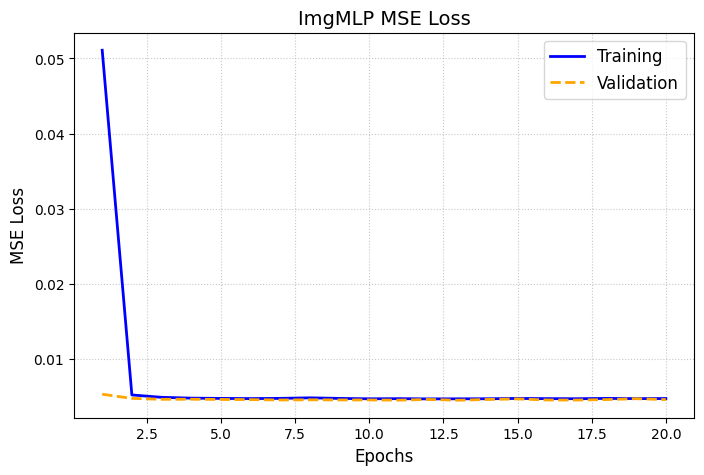

Training Image Model on cuda
Epoch [1/20] | Train Loss: 0.17922 | Val Loss: 0.06744
Epoch [2/20] | Train Loss: 0.05070 | Val Loss: 0.05155
Epoch [3/20] | Train Loss: 0.04322 | Val Loss: 0.03754
Epoch [4/20] | Train Loss: 0.03577 | Val Loss: 0.03240
Epoch [5/20] | Train Loss: 0.02974 | Val Loss: 0.02623
Epoch [6/20] | Train Loss: 0.02500 | Val Loss: 0.02383
Epoch [7/20] | Train Loss: 0.02302 | Val Loss: 0.02171
Epoch [8/20] | Train Loss: 0.02044 | Val Loss: 0.01903
Epoch [9/20] | Train Loss: 0.01856 | Val Loss: 0.01746
Epoch [10/20] | Train Loss: 0.01697 | Val Loss: 0.01603
Epoch [11/20] | Train Loss: 0.01581 | Val Loss: 0.01523
Epoch [12/20] | Train Loss: 0.01513 | Val Loss: 0.01477
Epoch [13/20] | Train Loss: 0.01470 | Val Loss: 0.01441
Epoch [14/20] | Train Loss: 0.01436 | Val Loss: 0.01408
Epoch [15/20] | Train Loss: 0.01406 | Val Loss: 0.01383
Epoch [16/20] | Train Loss: 0.01378 | Val Loss: 0.01388
Epoch [17/20] | Train Loss: 0.01388 | Val Loss: 0.01358
Epoch [18/20] | Train Loss: 

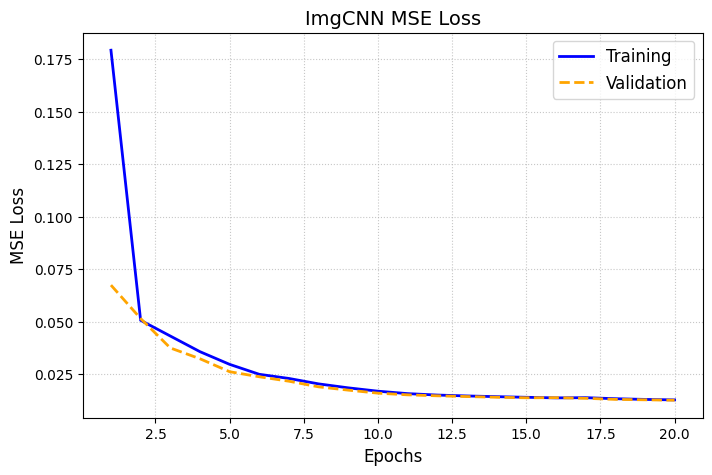

In [11]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    print("IMAGE GENERATION")
    img_dataset = ImagePredictionDataset(num_processes=4)

    total_size = len(img_dataset)
    train_size = int(0.8 * total_size)
    val_size = total_size - train_size
    img_train_set, img_val_set = random_split(img_dataset, [train_size, val_size])

    img_train_loader = DataLoader(img_train_set, batch_size=64, shuffle=True)
    img_val_loader = DataLoader(img_val_set, batch_size=64, shuffle=False)

    print(f"Split {total_size} images -> {train_size} Train | {val_size} Val\n")

    # Train ImgMLP
    trained_img_mlp, img_mlp_train_loss, img_mlp_val_loss = train_img_model(
        ImgMLP(), img_train_loader, img_val_loader, epochs=20, lr=0.001, device=device
    )
    plot_learning_curves(img_mlp_train_loss, img_mlp_val_loss, title="ImgMLP MSE Loss")

    # Train ImgCNN
    trained_img_cnn, img_cnn_train_loss, img_cnn_val_loss = train_img_model(
        ImgCNN(), img_train_loader, img_val_loader, epochs=20, lr=0.001, device=device
    )
    plot_learning_curves(img_cnn_train_loss, img_cnn_val_loss, title="ImgCNN MSE Loss")

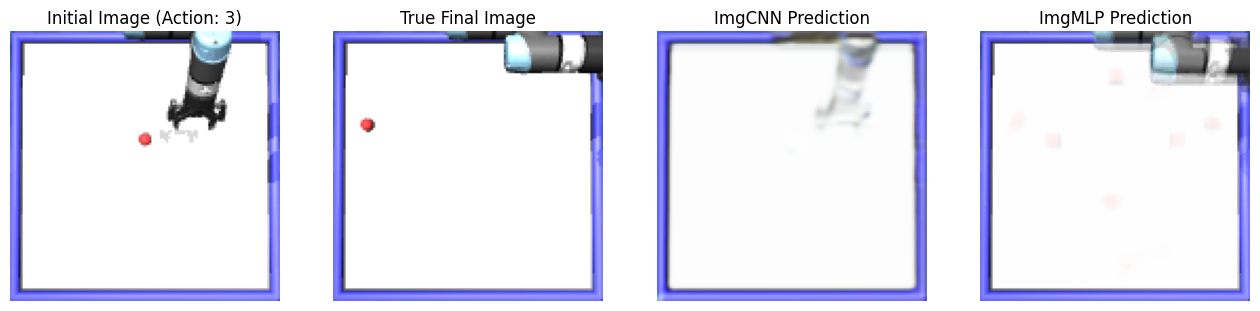

In [ ]:
# Visualizing using the validation set
test_init_img, test_action, test_final_img = img_val_set[0]
test_init_img_batch = test_init_img.unsqueeze(0).to(device)
test_action_batch = test_action.unsqueeze(0).to(device)

trained_img_cnn.eval()
trained_img_mlp.eval()
with torch.no_grad():
    cnn_pred = trained_img_cnn(test_init_img_batch, test_action_batch).squeeze(0).cpu()
    mlp_pred = trained_img_mlp(test_init_img_batch, test_action_batch).squeeze(0).cpu()

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(test_init_img.permute(1, 2, 0).numpy())
axes[0].set_title(f"Initial Image (Action: {test_action.item()})")
axes[1].imshow(test_final_img.permute(1, 2, 0).numpy())
axes[1].set_title("True Final Image")
axes[2].imshow(cnn_pred.permute(1, 2, 0).numpy())
axes[2].set_title("ImgCNN Prediction")
axes[3].imshow(mlp_pred.permute(1, 2, 0).numpy())
axes[3].set_title("ImgMLP Prediction")
for ax in axes: ax.axis('off')
plt.show()

Using device: cuda

POSITION PREDICTION
Workspace Bounds (Normalization Factors) -> X: [0.304, 1.134], Y: [-0.417, 0.420]

Training Position Model on cuda
Epoch [1/30] | Train MSE: 0.08553 | Val MSE: 0.07207 | Val Dist: 0.3047
Epoch [2/30] | Train MSE: 0.07568 | Val MSE: 0.06829 | Val Dist: 0.2958
Epoch [3/30] | Train MSE: 0.07537 | Val MSE: 0.06874 | Val Dist: 0.2978
Epoch [4/30] | Train MSE: 0.07477 | Val MSE: 0.06889 | Val Dist: 0.2976
Epoch [5/30] | Train MSE: 0.07451 | Val MSE: 0.06872 | Val Dist: 0.2979
Epoch [6/30] | Train MSE: 0.07495 | Val MSE: 0.06853 | Val Dist: 0.2971
Epoch [7/30] | Train MSE: 0.07470 | Val MSE: 0.06871 | Val Dist: 0.2974
Epoch [8/30] | Train MSE: 0.07442 | Val MSE: 0.06883 | Val Dist: 0.2983
Epoch [9/30] | Train MSE: 0.07473 | Val MSE: 0.06920 | Val Dist: 0.2984
Epoch [10/30] | Train MSE: 0.07462 | Val MSE: 0.06848 | Val Dist: 0.2967
Epoch [11/30] | Train MSE: 0.07511 | Val MSE: 0.06938 | Val Dist: 0.2997
Epoch [12/30] | Train MSE: 0.07483 | Val MSE: 0.068

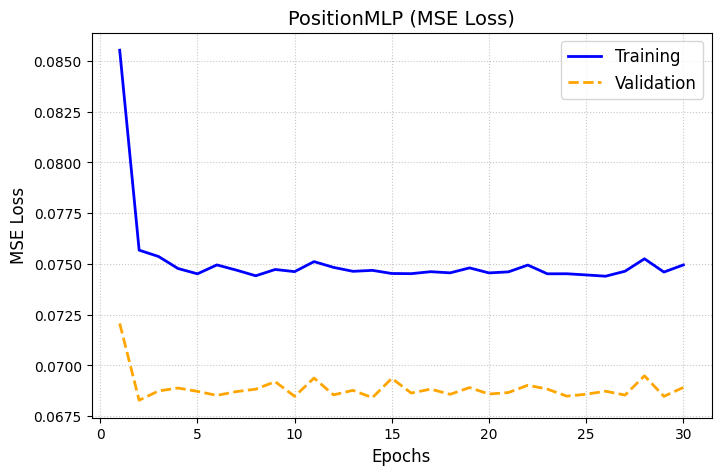

Training Position Model on cuda
Epoch [1/30] | Train MSE: 0.08060 | Val MSE: 0.06728 | Val Dist: 0.2948
Epoch [2/30] | Train MSE: 0.06877 | Val MSE: 0.05445 | Val Dist: 0.2613
Epoch [3/30] | Train MSE: 0.02610 | Val MSE: 0.00726 | Val Dist: 0.0939
Epoch [4/30] | Train MSE: 0.00799 | Val MSE: 0.00761 | Val Dist: 0.0978
Epoch [5/30] | Train MSE: 0.00761 | Val MSE: 0.00692 | Val Dist: 0.0932
Epoch [6/30] | Train MSE: 0.00737 | Val MSE: 0.00745 | Val Dist: 0.0945
Epoch [7/30] | Train MSE: 0.00729 | Val MSE: 0.00680 | Val Dist: 0.0922
Epoch [8/30] | Train MSE: 0.00716 | Val MSE: 0.00686 | Val Dist: 0.0930
Epoch [9/30] | Train MSE: 0.00745 | Val MSE: 0.00679 | Val Dist: 0.0927
Epoch [10/30] | Train MSE: 0.00740 | Val MSE: 0.00700 | Val Dist: 0.0938
Epoch [11/30] | Train MSE: 0.00736 | Val MSE: 0.00692 | Val Dist: 0.0932
Epoch [12/30] | Train MSE: 0.00731 | Val MSE: 0.00721 | Val Dist: 0.0949
Epoch [13/30] | Train MSE: 0.00726 | Val MSE: 0.00670 | Val Dist: 0.0919
Epoch [14/30] | Train MSE: 0

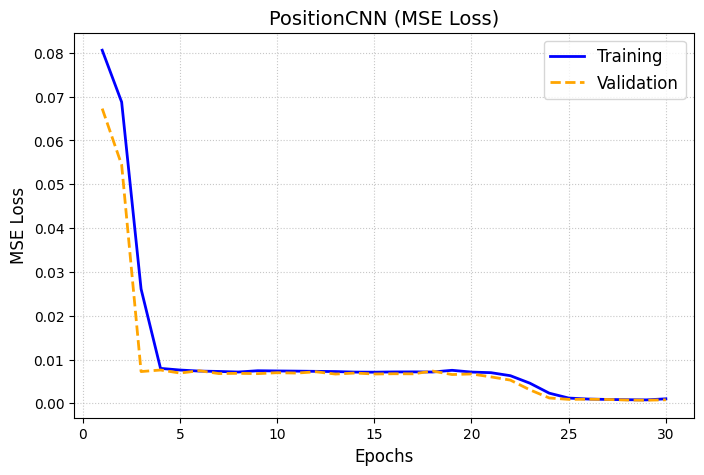

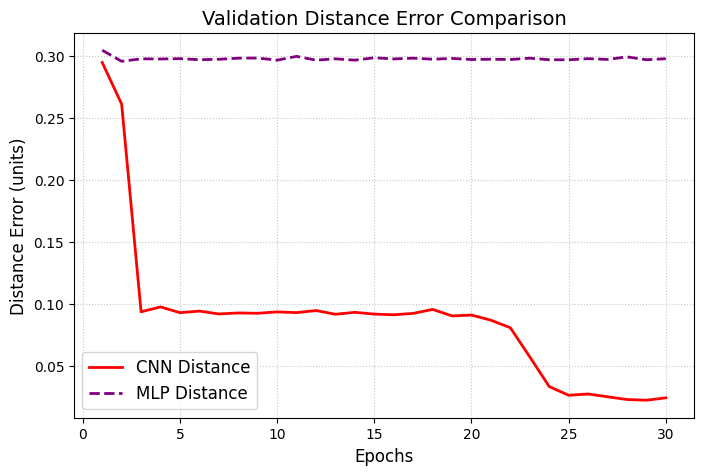

In [ ]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    print("POSITION PREDICTION")
    pos_dataset = PositionPredictionDataset(num_processes=4)

    pos_train_set, pos_val_set = random_split(pos_dataset, [train_size, val_size])
    pos_train_loader = DataLoader(pos_train_set, batch_size=64, shuffle=True)
    pos_val_loader = DataLoader(pos_val_set, batch_size=64, shuffle=False)

    print(f"Workspace Bounds (Normalization Factors) -> X: [{pos_dataset.pos_min[0]:.3f}, {pos_dataset.pos_max[0]:.3f}], Y: [{pos_dataset.pos_min[1]:.3f}, {pos_dataset.pos_max[1]:.3f}]\n")

    # PositionMLP
    trained_pos_mlp, pos_mlp_train_mse, pos_mlp_val_mse, pos_mlp_val_dist = train_position_model(
        PositionMLP(), pos_train_loader, pos_val_loader, pos_dataset, epochs=30, lr=0.0001, device=device
    )
    mlp_error = evaluate_distance_error(trained_pos_mlp, pos_val_loader, pos_dataset, device=device)
    print(f"PositionMLP Validation Distance Error: {mlp_error:.4f} units\n")

    plot_learning_curves(pos_mlp_train_mse, pos_mlp_val_mse, title="PositionMLP (MSE Loss)")

    # PositionCNN
    trained_pos_cnn, pos_cnn_train_mse, pos_cnn_val_mse, pos_cnn_val_dist = train_position_model(
        PositionCNN(), pos_train_loader, pos_val_loader, pos_dataset, epochs=30, lr=0.001, device=device
    )
    cnn_error = evaluate_distance_error(trained_pos_cnn, pos_val_loader, pos_dataset, device=device)
    print(f"PositionCNN Validation Distance Error: {cnn_error:.4f} units\n")

    plot_learning_curves(pos_cnn_train_mse, pos_cnn_val_mse, title="PositionCNN (MSE Loss)")

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(pos_cnn_val_dist) + 1), pos_cnn_val_dist, color='red', linewidth=2, label="CNN Distance")
    plt.plot(range(1, len(pos_mlp_val_dist) + 1), pos_mlp_val_dist, color='purple', linewidth=2, linestyle='--', label="MLP Distance")
    plt.title("Validation Distance Error Comparison", fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Distance Error (units)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()

# Test

In [14]:
def evaluate_img_test_set(model, test_loader, device="cpu"):
    model.eval()
    J = nn.MSELoss()
    running_loss = 0.0
    with torch.no_grad():
        for init_imgs, actions, final_imgs in test_loader:
            init_imgs, actions, final_imgs = init_imgs.to(device), actions.to(device), final_imgs.to(device)
            predictions = model(init_imgs, actions)
            loss = J(predictions, final_imgs)
            running_loss += loss.item() * init_imgs.size(0)
    return running_loss / len(test_loader.dataset)

if __name__ == "__main__":
    print("\n" + "="*50)
    print("TEST SET EVALUATION")
    print("="*50)

    print("\nLoading Image Test Data")
    img_test_dataset = ImagePredictionDataset(num_processes=4, is_test=True)
    img_test_loader = DataLoader(img_test_dataset, batch_size=32, shuffle=False)
    print(f"Loaded {len(img_test_dataset)} test samples.")

    img_mlp_test_loss = evaluate_img_test_set(trained_img_mlp, img_test_loader, device)
    img_cnn_test_loss = evaluate_img_test_set(trained_img_cnn, img_test_loader, device)

    print(f"ImgMLP Test MSE: {img_mlp_test_loss:.5f}")
    print(f"ImgCNN Test MSE: {img_cnn_test_loss:.5f}")

    print("\nLoading Position Test Data")
    pos_test_dataset = PositionPredictionDataset(
        num_processes=4,
        is_test=True,
        train_min=pos_dataset.pos_min,
        train_max=pos_dataset.pos_max
    )
    pos_test_loader = DataLoader(pos_test_dataset, batch_size=32, shuffle=False)
    print(f"Loaded {len(pos_test_dataset)} test samples.")

    mlp_test_dist = evaluate_distance_error(trained_pos_mlp, pos_test_loader, pos_test_dataset, device)
    cnn_test_dist = evaluate_distance_error(trained_pos_cnn, pos_test_loader, pos_test_dataset, device)

    print(f"PositionMLP Final Test Distance Error: {mlp_test_dist:.4f} units")
    print(f"PositionCNN Final Test Distance Error: {cnn_test_dist:.4f} units")


TEST SET EVALUATION

Loading Image Test Data
Loaded 200 test samples.
ImgMLP Test MSE: 0.00443
ImgCNN Test MSE: 0.01260

Loading Position Test Data
Loaded 200 test samples.
PositionMLP Final Test Distance Error: 0.3071 units
PositionCNN Final Test Distance Error: 0.0273 units


5 TEST SET VISUALIZATIONS



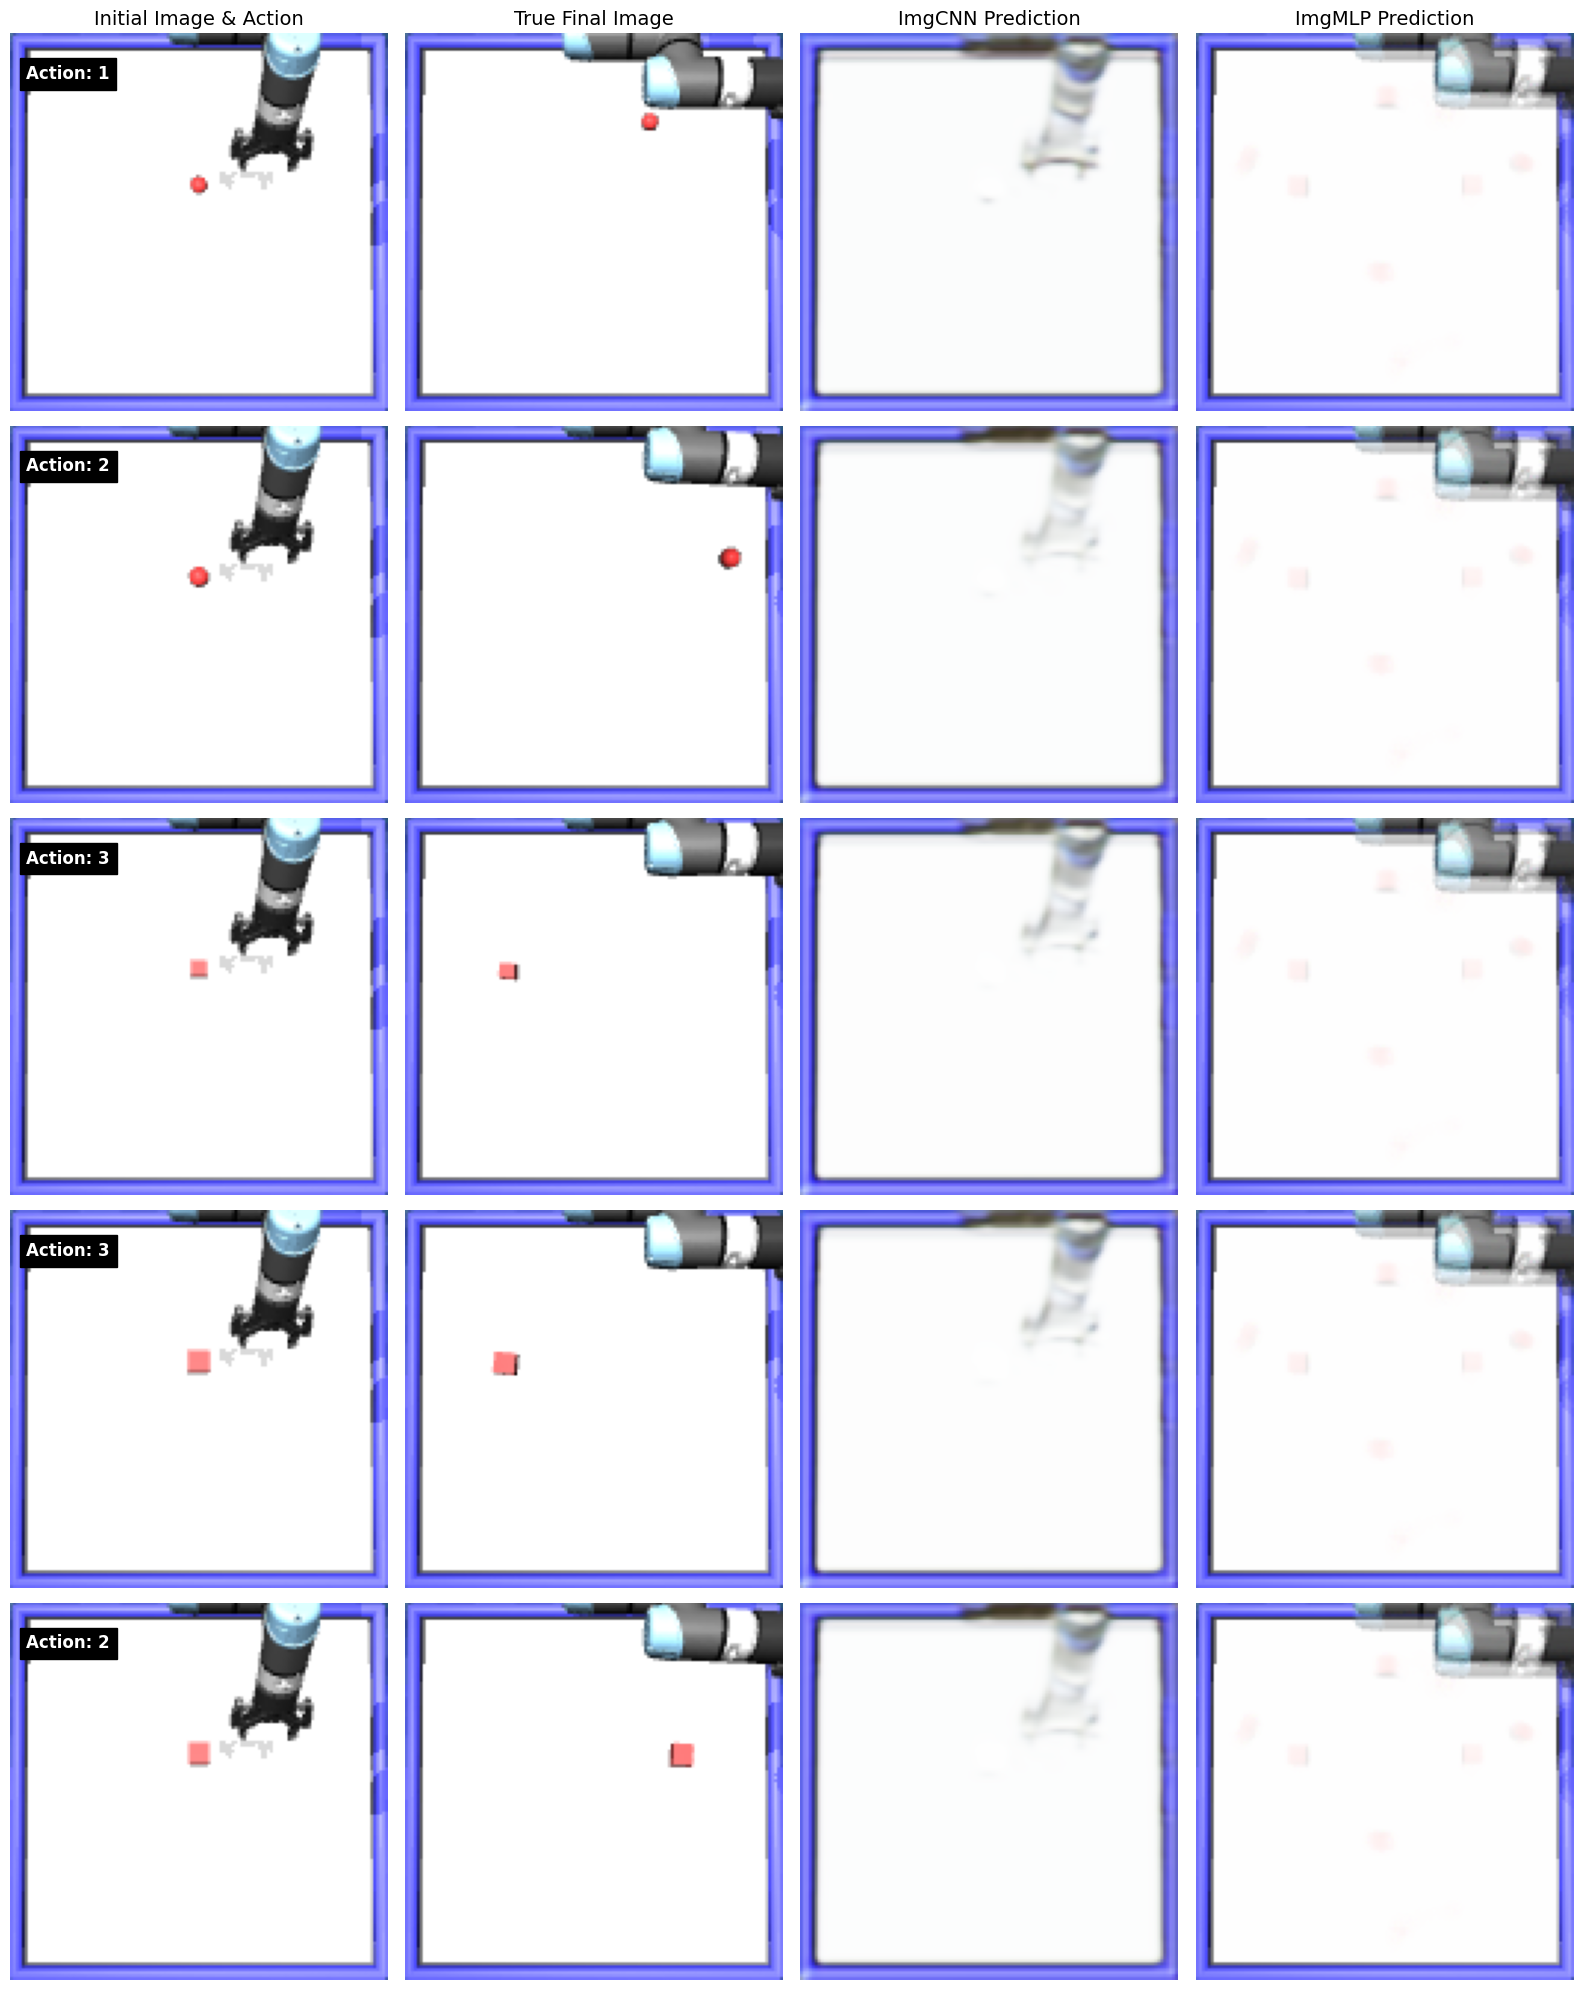

In [15]:
def visualize_test_predictions(img_dataset, cnn_model, mlp_model, device, num_samples=5):
    # 5 random indices from the test set
    indices = np.random.choice(len(img_dataset), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

    cnn_model.eval()
    mlp_model.eval()

    with torch.no_grad():
        for row_idx, data_idx in enumerate(indices):
            init_img, action, true_final_img = img_dataset[data_idx]

            # .unsqueeze() adds some kind of a fake batch_size dimension
            # which is needed to pass data to NN
            init_batch = init_img.unsqueeze(0).to(device)
            action_batch = action.unsqueeze(0).to(device)

            cnn_pred = cnn_model(init_batch, action_batch).squeeze(0).cpu()
            mlp_pred = mlp_model(init_batch, action_batch).squeeze(0).cpu()

            # Initial image
            ax = axes[row_idx, 0]
            ax.imshow(init_img.permute(1, 2, 0).numpy())
            ax.axis('off')
            ax.text(5, 15, f"Action: {action.item()}", color='white',
                    backgroundcolor='black', fontsize=12, fontweight='bold')
            if row_idx == 0: ax.set_title("Initial Image & Action", fontsize=14)

            # True final image
            ax = axes[row_idx, 1]
            ax.imshow(true_final_img.permute(1, 2, 0).numpy())
            ax.axis('off')
            if row_idx == 0: ax.set_title("True Final Image", fontsize=14)

            # ImgCNN prediction
            ax = axes[row_idx, 2]
            ax.imshow(cnn_pred.permute(1, 2, 0).numpy())
            ax.axis('off')
            if row_idx == 0: ax.set_title("ImgCNN Prediction", fontsize=14)

            # ImgMLP prediction
            ax = axes[row_idx, 3]
            ax.imshow(mlp_pred.permute(1, 2, 0).numpy())
            ax.axis('off')
            if row_idx == 0: ax.set_title("ImgMLP Prediction", fontsize=14)

    plt.tight_layout()
    plt.show()

print("5 TEST SET VISUALIZATIONS\n")
visualize_test_predictions(img_test_dataset, trained_img_cnn, trained_img_mlp, device, num_samples=5)